In [4]:
!pip install imutils


  Using cached imutils-0.5.4-py3-none-any.whl


In [5]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image


2024-03-02 11:26:30.973179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 11:26:30.973312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 11:26:31.154874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
.
|-- TEST
|   |-- NO
|   `-- YES
|-- TRAIN
|   |-- NO
|   `-- YES
`-- VAL
    |-- NO
    `-- YES

9 directories


In [7]:
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [8]:
def loadData(path, imgSize):
    x = []
    y = []
    labels = os.listdir(path)
    i = 0
    for label in labels:
        files = os.listdir(path + label)
        for file in files:
            img = image.load_img(path + label + '/' + file, target_size=imgSize)
            img = image.img_to_array(img)
            img = preprocess_input(img)
            x.append(img)
            y.append(i)
        i = i + 1
    x = np.array(x)
    y = np.array(y)
    print(f'{len(x)} images loaded from {path} directory.')
    return x, y, labels


In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap=cmap)

    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)

    plt.tight_layout()

    plt.show()


In [10]:
trainDir='TRAIN/'
testDir='TEST/'
valDir='VAL/'
imgSize=(224,224)
x_train,y_train,labels=loadData(trainDir,imgSize)
x_test,y_test,_=loadData(testDir,imgSize)
x_val,y_val,_=loadData(valDir,imgSize)
y=dict()
y[0]=[]
y[1]=[]



193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


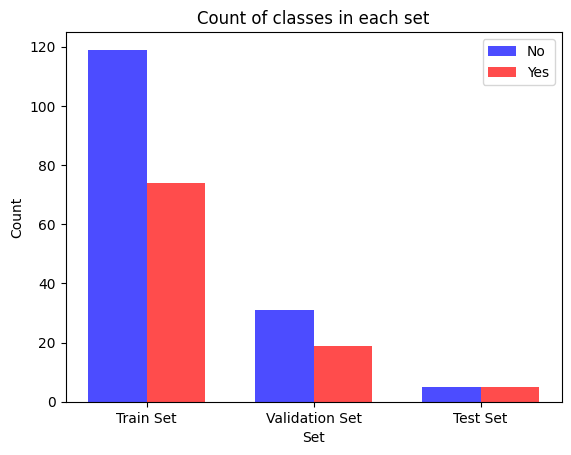

In [11]:
import matplotlib.pyplot as plt

y = dict()
y[0] = []
y[1] = []
set_names = ['Train Set', 'Validation Set', 'Test Set']

for set_name in [y_train, y_val, y_test]:
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

bar_width = 0.35
index = np.arange(len(set_names))

fig, ax = plt.subplots()
bars1 = ax.bar(index - bar_width/2, y[0], bar_width, label='No', color='blue', alpha=0.7)
bars2 = ax.bar(index + bar_width/2, y[1], bar_width, label='Yes', color='red', alpha=0.7)

ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_title('Count of classes in each set')
ax.set_xticks(index)
ax.set_xticklabels(set_names)
ax.legend()

plt.show()


In [12]:
from matplotlib.gridspec import GridSpec

def plot_samples(X, y, labels_dict, n=50):
    
    fig = plt.figure(figsize=(15, 6))

    num_classes = len(labels_dict)
    j = 10
    i = int(n / j)

    gs = GridSpec(i, j, figure=fig)

    for index in range(num_classes):
        imgs = X[np.argwhere(y == index)][:n]

        for c in range(min(n, len(imgs))):
            ax = fig.add_subplot(gs[c])
            ax.imshow(imgs[c][0])
            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.tight_layout()

    plt.show()


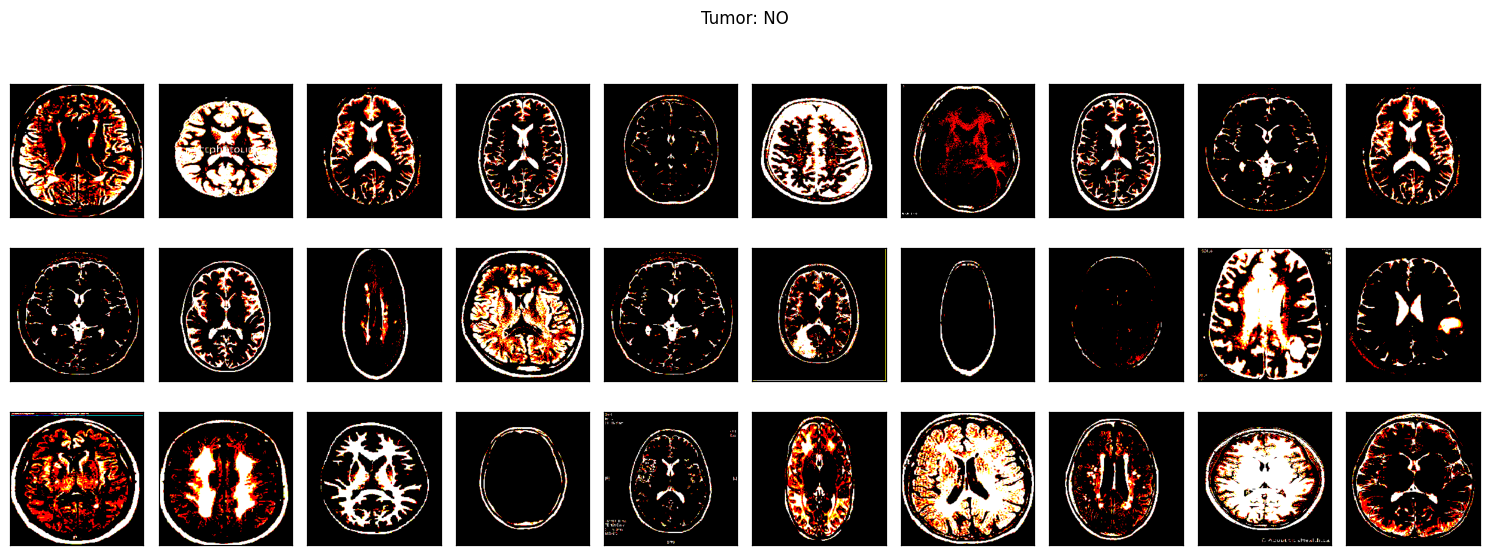

In [13]:
plot_samples(x_train, y_train, labels, 30)

In [34]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in vgg.layers:
    layer.trainable = False

model = Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
   layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the training and validation directories
train_generator = train_datagen.flow_from_directory(
    trainDir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    valDir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)







Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step - accuracy: 0.6756 - loss: 0.6412 - val_accuracy: 0.7188 - val_loss: 0.5615
Epoch 2/30
1/6 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.5312 - loss: 0.7847

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 864ms/step - accuracy: 0.5312 - loss: 0.4577 - val_accuracy: 0.6667 - val_loss: 0.5192
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.6813 - loss: 0.6196 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6250 - loss: 0.3510 - val_accuracy: 0.6875 - val_loss: 0.5667
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.7390 - loss: 0.6184 - val_accuracy: 0.7778 - val_loss: 0.4856
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7500 - loss: 0.3094 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.8177 - loss: 0.4101 - val_accuracy: 0.8125 - val_loss: 0.4441
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 873ms/step - accuracy: 0.8125 - loss: 0.1943 - val_accuracy: 0.8889 - val_loss: 0.3839
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.8058 - loss: 0.3835 - val_accuracy: 0.0000e+00 - val_loss: 

In [36]:
val_loss, val_acc = model.evaluate(validation_generator)
print('Test accuracy:', val_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.8413 - loss: 0.3597
Test accuracy: 0.8399999737739563
